In [2]:
pwd

'/home/md06/public/jupytercode/kxy/ADK-568/分子指纹/8-子结构'

In [3]:
from matplotlib import font_manager, pyplot as plt

# 查找系统中所有可用的Times New Roman字体的路径
times_new_roman = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# 从列表中找到一个指定的字体名称，并确保字体能支持加粗
t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f and 'Bold' in f]

if t_nr_path:
    # 如果找到了Times New Roman Bold字体，设置为默认字体
    prop = font_manager.FontProperties(fname=t_nr_path[0])
    plt.rcParams['font.family'] = prop.get_name()
    plt.rcParams['font.weight'] = 'bold'  # 设置字体为加粗
else:
    # 如果没有找到加粗的Times New Roman，尝试设置为普通的Times New Roman并加粗
    t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f]
    if t_nr_path:
        prop = font_manager.FontProperties(fname=t_nr_path[0])
        plt.rcParams['font.family'] = prop.get_name()
        plt.rcParams['font.weight'] = 'bold'
    else:
        # 如果没有找到Times New Roman，使用默认的衬线字体并设置为加粗
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.weight'] = 'bold'

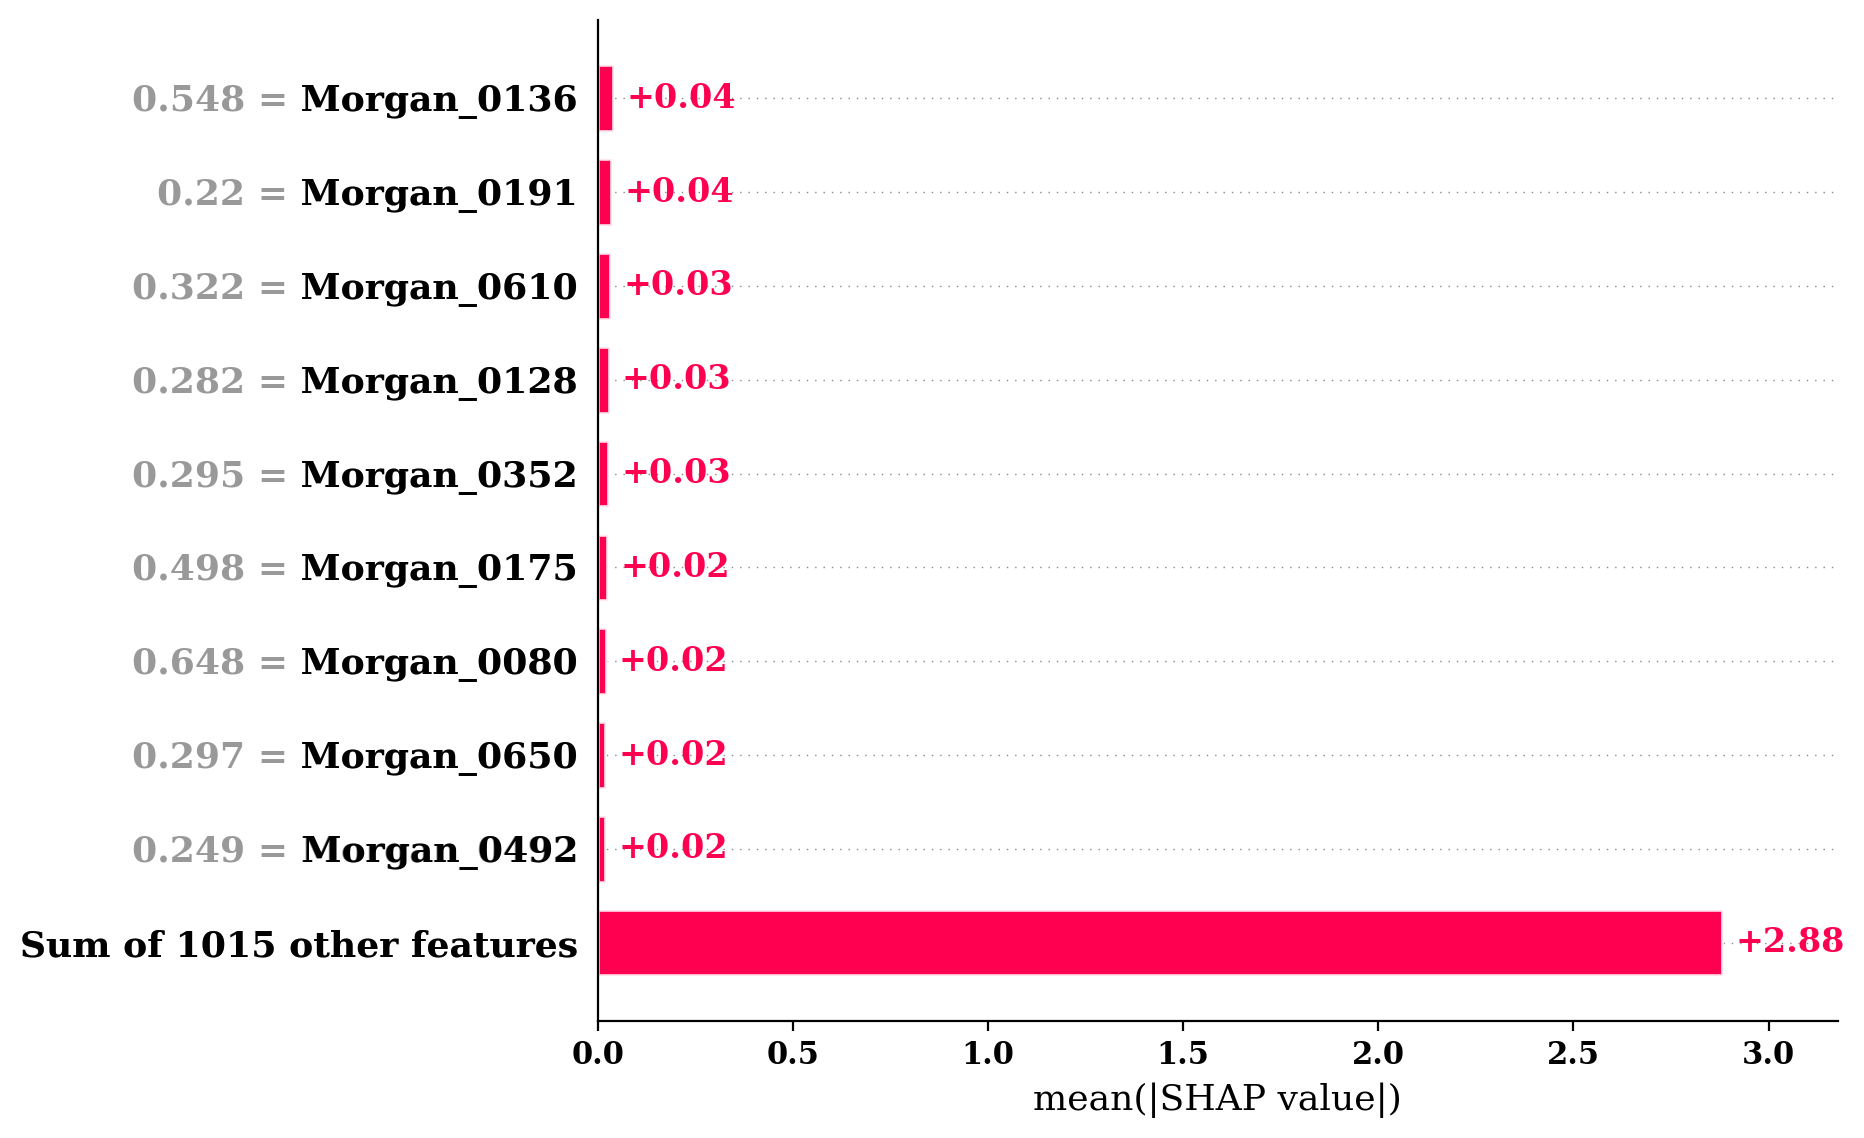

In [38]:
shap.plots.bar(shap_values2,show_data=True,max_display=10)
# Save the plot as a TIFF file
#plt.savefig('shap_values_plot.png', format='png')
#plt.close()

##### 绘制默认效果的Summary_plot图
##### Y轴：展示了各个特征,每一个特征都有自己的一行，所有的特征都被排列在一起，便于查看和比较。
##### X轴：SHAP值,衡量了每个特征对模型预测的贡献大小。正值表示增加预测结果的可能性，负值表示减小预测结果的可能性。

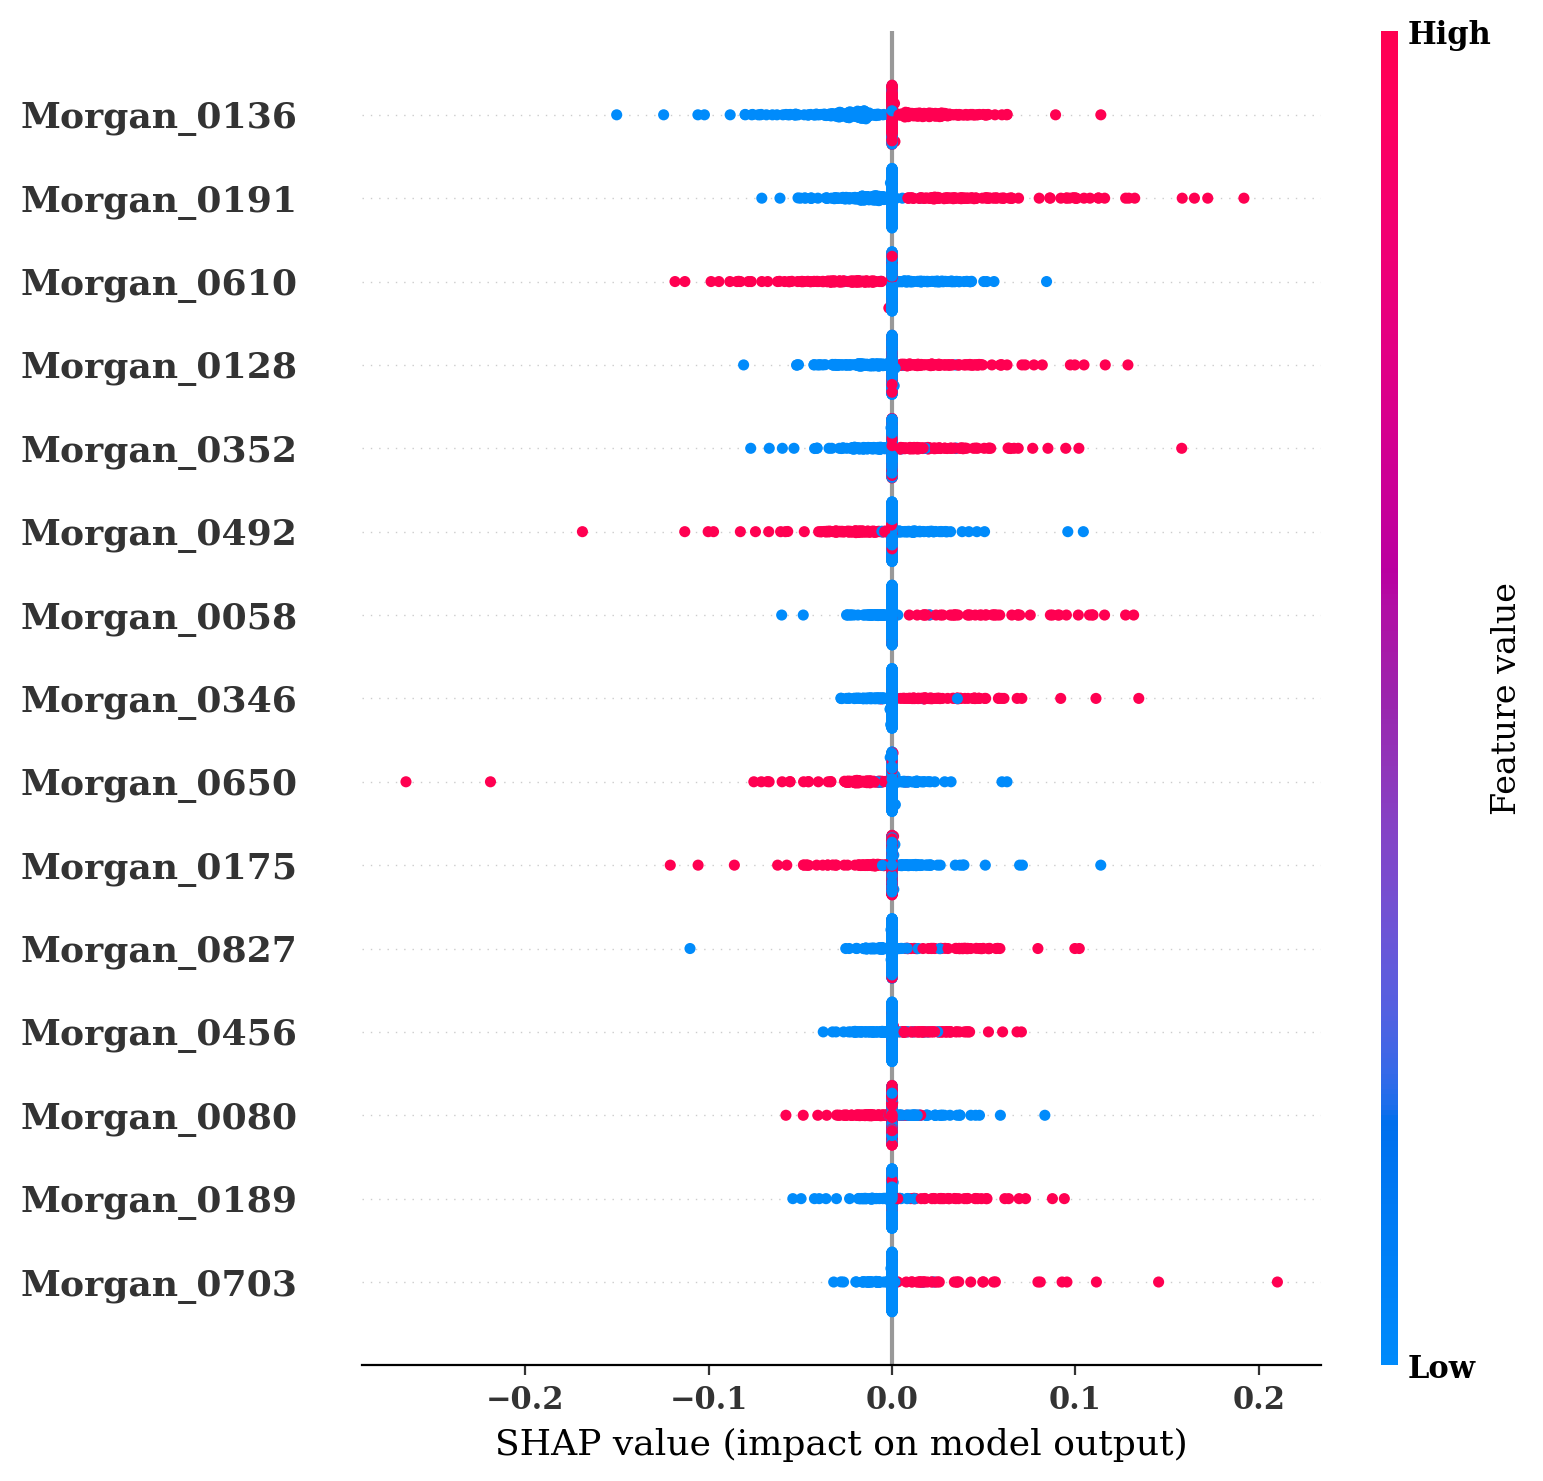

In [10]:
shap.summary_plot(shap_values, train_X, show=False,max_display=15,)
plt.savefig('单个特征重要度蜂群图-15.svg', format='svg',bbox_inches="tight")

##### Heatmap Plot热图显示了一个数据集的整体子结构，其中样本和特征都通过它们的 shap values 进行聚类排序，以便显示出数据的内在结构。
##### 默认使用 shap.utils.hclust_ordering 进行聚类。这对于理解模型在整个数据集上的行为非常有用。
##### 在热图矩阵上方是模型的输出，灰色虚线是基线(.base_value），图右侧的条形图是每个模型输入的全局重要性（默认用shap.order.abs.mean整体重要性来度量）。
##### 热图 x 轴上是样本、y 轴上是模型输入以及色标上是编码的 SHAP 值。

In [ ]:
# 更改特征排序，默认情况下feature_values=shap.Explanation.abs.mean(0)，还可以在所有样本中按特征的最大绝对值进行排序。
shap.plots.heatmap(shap_values_explanation_class1, 
                   feature_values=shap_values_explanation_class1.abs.max(0))

## 展示某个特征从小变大时对预测结果的shap值

In [ ]:
columns = train_X.columns
columns

In [ ]:
for i in columns:
    shap.dependence_plot(i, shap_values[1],  train_X, interaction_index=None, show=False)
    plt.savefig(i + '特征预测结果的shap值图[1]_点图.svg', format='svg',bbox_inches="tight")

In [ ]:
for i in columns:
    shap.partial_dependence_plot(i, RF.predict, train_X, model_expected_value=True, feature_expected_value=True,show=False)
    plt.savefig(i + '特征预测结果的shap值图[1]_线图.svg',format='svg',bbox_inches="tight")

## 特征间相互影响图

In [ ]:
import itertools
combination_features = list(itertools.combinations(columns, 2))
combination_features
for i in combination_features:
    feat_name1 = i[0]
    feat_name2 = i[1]
    shap.dependence_plot( feat_name1, shap_values[1], train_X, interaction_index=feat_name2, show=False)
    plt.savefig(i[0] + '_'+ i[1] +'相互影响[1]_点图.svg',format='svg',bbox_inches="tight")

## 描述符可视化

#### MolLogP可视化
LogP表示脂水分配系数，该值认为与细胞通透性有一定相关性。rdkit中提供的Descriptors.MolLogP()方法可以粗略计算logP值，
该方法首先做了一个原子分类系统，根据原子及其相连原子的不同而进行分类，再对化学性质相似、logP贡献相似的类别做合并，
最终得到了68种精确的原子类别和4种通配类别，并用SMARTS表示。计算时，对一个分子中所有原子进行分类，再乘以每一类的权重并加和，最终得到LogP值。
该方法在9920个分子的训练集上的r2为0.918，标准差为0.667。此外摩尔折射率（molar refractivity，MR）也可以通过这种方法计算得到。

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [ ]:
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
contribs[:3]

In [ ]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, [x for x,y in contribs])

# 子结构可视化

## 分子指纹映射单个子结构

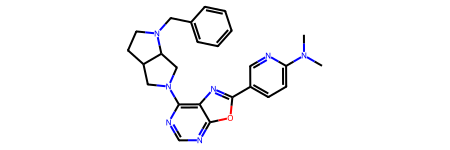

In [147]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
smi = 'CN(C)c1ccc(-c2nc3c(N4CC5CCN(Cc6ccccc6)C5C4)ncnc3o2)cn1'    # 分子smiles
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('[*]:[o]:[c]1:[n]:[cH]:[n]:[*]:[c]:1:[*]') # 子结构的SMARTS
mol

In [148]:
# # 判断是否包含子结构
mol.HasSubstructMatch(patt)

True

In [149]:
# 搜索并返回子结构
hit_at = mol.GetSubstructMatch(patt) 
print(hit_at)
# 获取匹配的原子和索引
hit_bond = []
for bond in patt.GetBonds():
    aid1 = hit_at[bond.GetBeginAtomIdx()]
    aid2 = hit_at[bond.GetEndAtomIdx()]
    hit_bond.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())
hit_bond

(7, 30, 29, 28, 27, 26, 10, 9, 8)


[33, 29, 28, 27, 26, 25, 9, 8, 34]

In [150]:
# 定义高亮颜色
highlightAtomColors = {
    idx: (0.25, 0.61, 0.88) for idx in hit_at  # 红色 (RGB: 1.0, 0.0, 0.0)
}
highlightBondColors = {
    idx: (0.25, 0.61, 0.88) for idx in hit_bond  # 绿色 (RGB: 0.0, 1.0, 0.0)
}

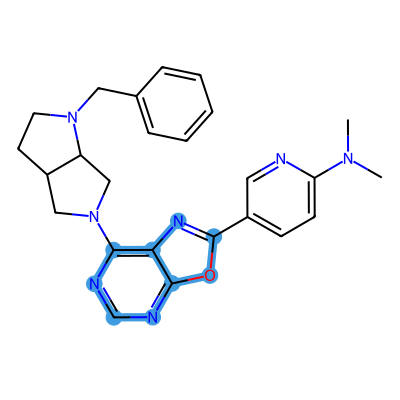

In [151]:
# 绘制分子和高亮子结构
d = rdMolDraw2D.MolDraw2DCairo(400, 400)  # 图像大小
rdMolDraw2D.PrepareAndDrawMolecule(
    d, mol, 
    highlightAtoms=list(hit_at),
    highlightBonds=hit_bond,
    highlightAtomColors=highlightAtomColors,
    highlightBondColors=highlightBondColors
)

# 完成绘制并保存图像
d.FinishDrawing()
d.WriteDrawingText('./number6/3.png')  # 保存图像
img = Image.open('./number6/3.png')
img # 显示图像

## 高亮展示多个匹配子结构

##### 5-Iodotubercidin

In [ ]:
# #   5-Iodotubercidin    CHEMBL99203   26nm
###############展示带序号的整个分子
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O')  ##整个分子
#为分子加上原子序号
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
add_atom_index(mol)
mol

In [ ]:
############ 输出没有原子序号的分子结构
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O') #整个分子
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
mol

##### ABT-702

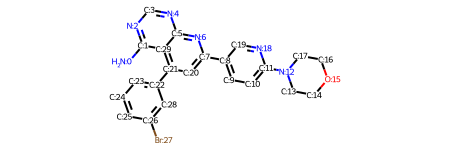

In [73]:
#   ABT-702    CHEMBL66089    1.7nM
###############展示带序号的整个分子
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12')  ##整个分子
#为分子加上原子序号
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
add_atom_index(mol)
mol

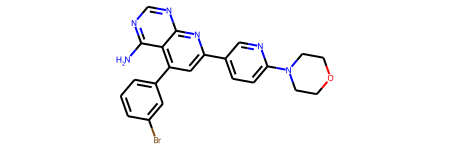

In [74]:
############ 输出没有原子序号的分子结构
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12') #整个分子
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
mol

##### GP3269

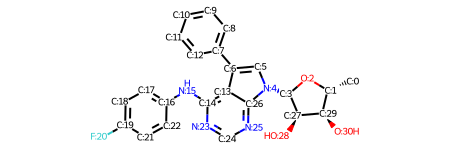

In [92]:
#  GP3269      CHEMBL66277       11nM
###############展示带序号的整个分子
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O')  ##整个分子
#为分子加上原子序号
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
add_atom_index(mol)
mol

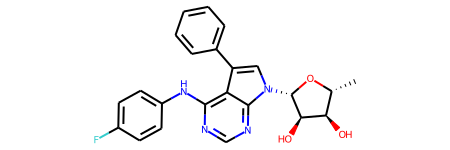

In [93]:
############ 输出没有原子序号的分子结构
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O') #整个分子
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
mol

{15: ((24, 2),), 64: ((24, 1),), 136: ((8, 1), (22, 1)), 147: ((0, 0),), 151: ((12, 2),), 217: ((18, 2),), 266: ((28, 2),), 323: ((22, 2),), 346: ((11, 2),), 352: ((21, 1),), 356: ((1, 0), (5, 0), (7, 0), (8, 0), (11, 0), (21, 0), (22, 0), (26, 0), (29, 0)), 365: ((5, 2),), 378: ((2, 0), (4, 0), (6, 0), (18, 0), (20, 2)), 379: ((4, 2),), 381: ((15, 2),), 407: ((12, 1),), 417: ((14, 2), (16, 2)), 428: ((2, 1), (4, 1), (18, 1)), 433: ((0, 1),), 435: ((1, 1),), 456: ((13, 1), (17, 1)), 463: ((19, 2),), 485: ((25, 2), (6, 2)), 489: ((3, 1),), 511: ((19, 1),), 523: ((15, 1),), 527: ((11, 1),), 537: ((21, 2),), 548: ((2, 2),), 600: ((5, 1),), 607: ((27, 1),), 635: ((10, 2),), 650: ((8, 2),), 656: ((15, 0),), 726: ((9, 1), (10, 1), (23, 1), (25, 1), (1, 2)), 728: ((27, 0),), 736: ((23, 2),), 766: ((26, 2),), 786: ((3, 2),), 827: ((29, 2),), 831: ((6, 1),), 849: ((3, 0), (9, 0), (10, 0), (19, 0), (20, 0), (23, 0), (24, 0), (25, 0), (28, 0)), 875: ((20, 1), (28, 1)), 896: ((9, 2),), 909: ((26, 

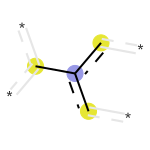

In [75]:
############### 展示想要高亮的片段
from rdkit.Chem import AllChem
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi) #nBits=1024,
print(bi) 
bi[136] #输入想显示分子指纹的位名
img = Draw.DrawMorganBit(mol, 136, bi, useSVG=False)
img

In [86]:
#####   16进制颜色转换为RGB
def hex_to_rgb(hex_color):
    # 去除前缀'#'并转换为三个十六进制的组成部分
    hex_color = hex_color.lstrip('#')
    # 分割成红绿蓝三部分，每部分2个字符，转换为十进制后除以255
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))
# 定义十六进制颜色代码
hex_colors = ['A1DD70']
# 转换颜色
rgb_colors = [hex_to_rgb(color) for color in hex_colors]
print(rgb_colors)

[(0.6313725490196078, 0.8666666666666667, 0.4392156862745098)]


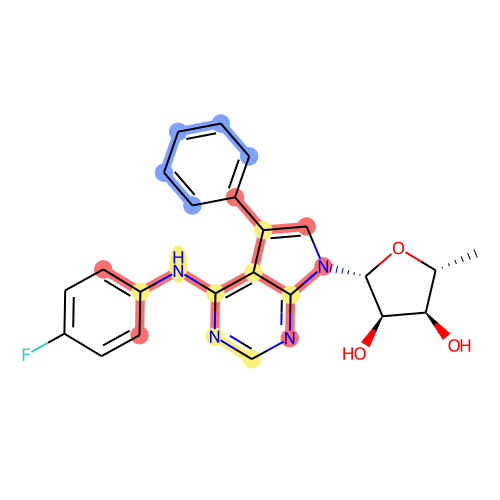

In [103]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display
from PIL import Image
import io
# 定义分子
#smiles = 'Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O'   # 5-ITU
#smiles = 'Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12'   #ABT-702
smiles = 'C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O'   #GP3269
mol = Chem.MolFromSmiles(smiles)
# 计算摩根指纹并获取位点信息
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi)

# 感兴趣的位点及其颜色
interest_bits = [191,389,741]
#interest_bits = [191,389,736,741]
colors = [(0.980, 0.439, 0.439), (0.494, 0.631, 1.0), 
          (0.976, 0.941, 0.478),(0.631,0.867,0.439)]  

# 初始化存储
highlight_atoms = {}
highlight_bonds = {}
for bit, color in zip(interest_bits, colors):
    if bit in bi:
        atom_info = bi[bit]
        for info in atom_info:
            atom_idx, radius = info
            # 特定筛选：例如对于位点191，只选择原子16和半径1
           # if (bit == 191 and not (atom_idx == 16 and radius == 1)):
            #    continue  # 跳过不符合条件的组合
            # 将所有相关原子按颜色分类
            if atom_idx not in highlight_atoms:
                highlight_atoms[atom_idx] = color
            if radius > 0:
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
                for bidx in env:
                    bond = mol.GetBondWithIdx(bidx)
                    if bidx not in highlight_bonds:
                        highlight_bonds[bidx] = color
                    highlight_atoms[bond.GetBeginAtomIdx()] = color
                    highlight_atoms[bond.GetEndAtomIdx()] = color
# 创建绘图对象
drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
drawer.DrawMolecule(mol, 
                    highlightAtoms=highlight_atoms.keys(), 
                    highlightAtomColors=highlight_atoms,
                    highlightBonds=highlight_bonds.keys(),
                    highlightBondColors=highlight_bonds)
drawer.FinishDrawing()
# 显示图像
img_data = drawer.GetDrawingText()
img = Image.open(io.BytesIO(img_data))
#img.save("5-Iodotubercidin-Morgan_786.png")
#img.save("ABT-702-Morgan_136-352-456-786.png")
img.save("GP3269-Morgan_136-191-741.png")
img

## 高亮不同分子间的不同子结构-例子

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.minFontSize=20

In [ ]:
mol1 = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O')
mol2 = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12')
mol3 = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O')
Draw.MolsToGridImage([mol1, mol2,mol3])

In [ ]:
##  原文链接：https://blog.csdn.net/qq_39889473/article/details/125695253
def view_difference(mol1, mol2,mol3):
    mcs = rdFMCS.FindMCS([mol1,mol2,mol3])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    match3 = mol3.GetSubstructMatch(mcs_mol)
    target_atm3 = []
    for atom in mol3.GetAtoms():
        if atom.GetIdx() not in match3:
            target_atm3.append(atom.GetIdx())    
    return Draw.MolsToGridImage([mol1, mol2,mol3],
                                highlightAtomLists=[target_atm1, target_atm2,target_atm3])      
view_difference(mol1,mol2,mol3)

In [ ]:
import numpy as np
import pandas as pd
import lime 
import lime.lime_tabular 
from sklearn import datasets 
from sklearn.ensemble import RandomForestClassifier 

# 加载数据
data = pd.read_csv('train-dataset-ECFPs.csv')

# 准备特征和目标变量
x_mor_train = data.iloc[:, 2:]  # 从第三列开始为特征数据
y_mor_train = data.iloc[:, 1]   # 第二列为目标变量
# x_mor_test = data2.iloc[:,2:]
# y_mor_test = data2.iloc[:,1:2]

# 将目标变量转换为一维数组
train_y = y_mor_train.values.flatten()
train_X = x_mor_train.values

# 定义目标名称和特征名称
target_names = ['inactive', 'active']
feature_names = data.columns[2:].tolist()

# 训练随机森林分类器
classifier = RandomForestClassifier()
classifier.fit(train_X, train_y)

# 创建LIME解释器
explainer = lime.lime_tabular.LimeTabularExplainer(
    train_X, 
    mode="classification",
    training_labels=train_y,
    feature_names=feature_names, 
    class_names=target_names, 
    discretize_continuous=True
)

# 选择一个实例进行解释
instance_index = 109  # 可以选择任何索引
instance = train_X[instance_index]

# 生成解释
explanation = explainer.explain_instance(
    instance, 
    classifier.predict_proba, 
    num_features=6
)

# 显示解释
explanation.show_in_notebook()

In [ ]:
import lime 
import lime.lime_tabular 
from sklearn import datasets 
from sklearn.ensemble import RandomForestClassifier 

data = pd.read_csv('train_dataset.csv')
x_mor_train = data.iloc[:,2:]   #第三列以后的数据，Python中索引是从0开始的
y_mor_train = data.iloc[:,1:2]  #左开右闭，读取第二列的数据
# x_mor_test = data2.iloc[:,2:]
# y_mor_test = data2.iloc[:,1:2]

train_X = np.array(x_mor_train)
train_y = np.array(y_mor_train).flatten()
target_names = ['inactive','active']

classifier = RandomForestClassifier()
classifier.fit(train_X, train_y) 

feature_names= data.columns.tolist()[2:]

# Create a LIME explainer object 
explainer = lime.lime_tabular.LimeTabularExplainer(train_X, mode="classification", 
                                                   training_labels=train_y,
                                                   feature_names=feature_names, 
                                                   class_names=target_names, 
                                                   discretize_continuous=True) 

# Select an instance to be explained (you can choose any index) 
instance = train_X[0] 

# Generate an explanation for the instance 
explanation = explainer.explain_instance(instance, classifier.predict_proba, num_features=5) 

# Display the explanation 
explanation.show_in_notebook()